# Detrend some variables on global grid

We do this in a separate notebook because it requires a few steps and quite a bit of resource.

In [2]:
from dask.distributed import Client,LocalCluster
from dask_jobqueue import PBSCluster

import bottleneck

In [3]:
# One node on Gadi has 48 cores - try and use up a full node before going to multiple nodes (jobs)

walltime = "00:10:00"
cores = 48
memory = str(4 * cores) + "GB"

cluster = PBSCluster(walltime=str(walltime), cores=cores, memory=str(memory), processes=cores,
                                          
                     job_extra_directives=["-q normal",
                                           "-P w42",
                                           "-l ncpus="+str(cores),
                                           "-l mem="+str(memory),
                                           "-l storage=gdata/w42+gdata/rt52"],
                     local_directory="$TMPDIR",
                     job_directives_skip=["select"])

In [4]:
cluster.scale(jobs=3)
client = Client(cluster)

In [5]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.6.129.27:37913,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [6]:
import xarray as xr

In [7]:
%cd /g/data/w42/dr6273/work/demand_model/

import functions as fn

/g/data/w42/dr6273/work/demand_model


In [8]:
era_path = "/g/data/w42/dr6273/work/data/era5/"

### First open the daily files, rechunk and store as zarr

I used 3 full nodes for this - takes a couple of minutes.

In [9]:
# Need to chunk when we open these files!
T = xr.open_mfdataset(era_path+"2t/daily/*.nc", chunks={"time": 500, "latitude": 500, "longitude": 300})

In [10]:
T.nbytes / 1024 ** 3

90.41259867325425

In [11]:
T = T.chunk({"time": -1, "latitude": 50, "longitude": 50})

In [12]:
T.to_zarr(
    "/scratch/w42/dr6273/tmp/2t_era5_daily_1959-2022.zarr",
    mode="w",
    consolidated=True
)

### Now process one latitude at a time, and append to a zarr store

24 cores.

In [8]:
T = xr.open_zarr(
    "/scratch/w42/dr6273/tmp/2t_era5_daily_1959-2022.zarr",
    consolidated=True,
    # chunks={"time": -1, "latitude": 1}
)

In [12]:
%%time
for i in range(len(T["latitude"].values)):
    lat = T["latitude"].values[i]
    T_ = T.isel(latitude=i)
    
    # detrended = data - fit + mean
    Tmean = T_["t2m"].mean("time")
    Tfit = fn.detrend_dim(T_["t2m"], "time").astype("float32")
    Tdt = Tfit + Tmean
    
    Tdt = Tdt.to_dataset(name="t2m")
    Tdt = Tdt.expand_dims({"latitude": [lat]})
    Tdt = Tdt.chunk({"time": -1, "longitude": -1})
    
    if i == 0:
        Tdt.to_zarr(
            "/scratch/w42/dr6273/tmp/2t_detrended_era5_daily_1959-2022_by_lat.zarr",
            mode="w",
            consolidated=True
        )
    else:
        Tdt.to_zarr(
            "/scratch/w42/dr6273/tmp/2t_detrended_era5_daily_1959-2022_by_lat.zarr",
            mode="a",
            append_dim="latitude",
            consolidated=True
        )

CPU times: user 9min 57s, sys: 51.6 s, total: 10min 49s
Wall time: 21min 18s


In [13]:
test = xr.open_zarr(
            "/scratch/w42/dr6273/tmp/2t_detrended_era5_daily_1959-2022_by_lat.zarr",
            consolidated=True
        )

In [14]:
test

<xarray.Dataset>
Dimensions:    (latitude: 721, longitude: 1440, time: 23376)
Coordinates:
  * latitude   (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * time       (time) datetime64[ns] 1959-01-01 1959-01-02 ... 2022-12-31
Data variables:
    t2m        (latitude, time, longitude) float32 dask.array<chunksize=(1, 23376, 1440), meta=np.ndarray>

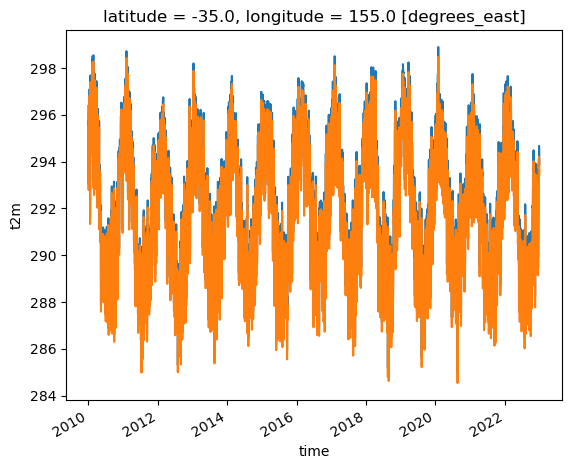

In [17]:
T.sel(latitude=-35, longitude=155, time=slice("2010", "2022")).t2m.plot()
test.sel(latitude=-35, longitude=155, time=slice("2010", "2022")).t2m.plot()